In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import pickle as pkl
import os
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [2]:
def drops(L):
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last:
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

In [3]:
def stability_window(y, mw_size):
    mw = deque()
    mw_average = []
    mw_std = []
    for i in y:
        mw.append(i)
        if len(mw) > mw_size:
            mw.popleft()
        mw_average.append(np.mean(mw))
        mw_std.append(np.std(mw))
    mw_average = np.array(mw_average)
    mw_std = np.array(mw_std)

    outliers_pos = []
    for pos, i in enumerate(y):
        if i < (mw_average - mw_std)[pos]:
            outliers_pos.append(pos)
            
    return mw_average, mw_std, outliers_pos

In [8]:
dataset = 'OIR5K'
classifier = 'rf'
meta_metrics_dict = dict()
retraining = False
for prefix in [12]:
    if retraining == True:
        performance = '../result/%s/%s/performance/rebalanced_True prefix_%s performance retrained.csv'%(dataset, classifier, prefix)
        label =pd.read_csv('../result/%s/%s/rebalanced_True label retrained.csv'%(dataset, classifier))
        variant =pd.read_csv('../result/%s/%s/rebalanced_True variant retrained.csv'%(dataset, classifier))
    else:
        performance = '../result/%s/%s/performance/rebalanced_True prefix_%s performance.csv'%(dataset, classifier, prefix)
        label =pd.read_csv('../result/%s/%s/rebalanced_True label.csv'%(dataset, classifier))
        variant =pd.read_csv('../result/%s/%s/rebalanced_True variant.csv'%(dataset, classifier))

    df = pd.read_csv(performance)
    variant = variant.loc[:, str(prefix)]
    print(np.corrcoef(df['fscore'], variant))
    mw_average, mw_std, outliers_pos = stability_window(df['fscore'],30)
    meta_metrics_dict[prefix] = {'Avg':0}
    average_fscore = round(np.average(df['fscore']),3)
    std_fscore = round(np.std(df['fscore']),2)
    meta_metrics_dict[prefix]['Avg'] = str(average_fscore) + ' '+'(%s)'%(std_fscore)
    # meta_metrics_dict[prefix]['Std'] = 


[[1.        0.9073593]
 [0.9073593 1.       ]]


array([[1.       , 0.9073593],
       [0.9073593, 1.       ]])

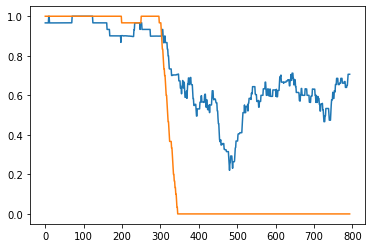

In [12]:
plt.plot(df['fscore'])
plt.plot(variant)
np.corrcoef(df['fscore'], variant)


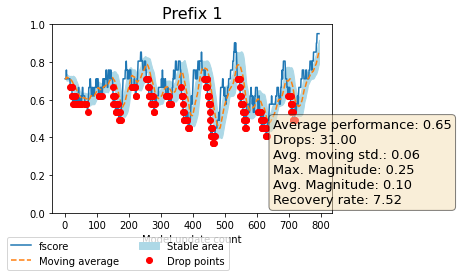

../img/OIR5K/hatc/Finished cases/prefix_1_fscore update.png


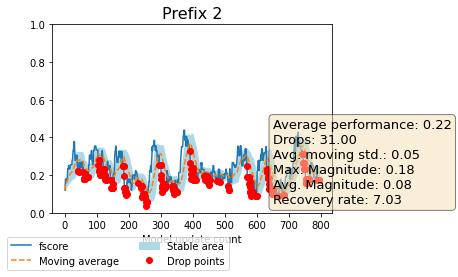

../img/OIR5K/hatc/Finished cases/prefix_2_fscore update.png


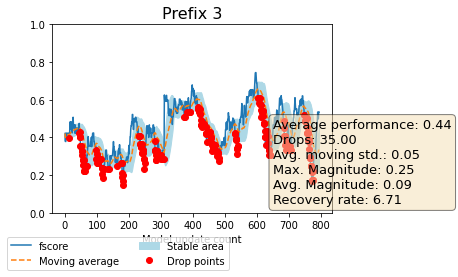

../img/OIR5K/hatc/Finished cases/prefix_3_fscore update.png


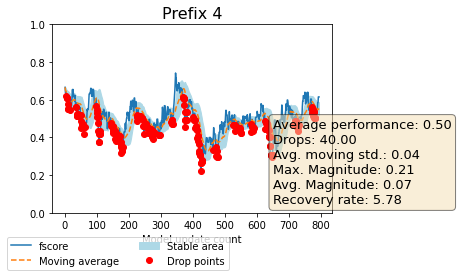

../img/OIR5K/hatc/Finished cases/prefix_4_fscore update.png


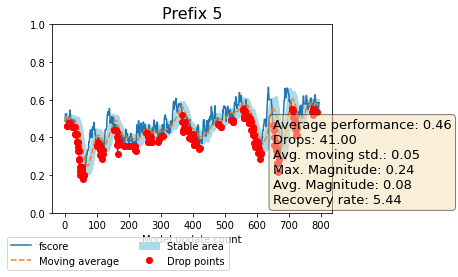

../img/OIR5K/hatc/Finished cases/prefix_5_fscore update.png


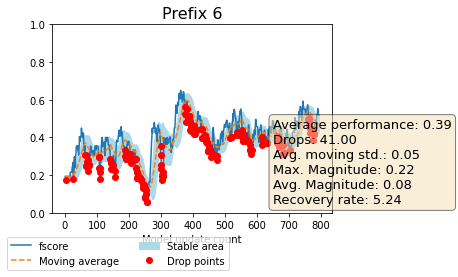

../img/OIR5K/hatc/Finished cases/prefix_6_fscore update.png


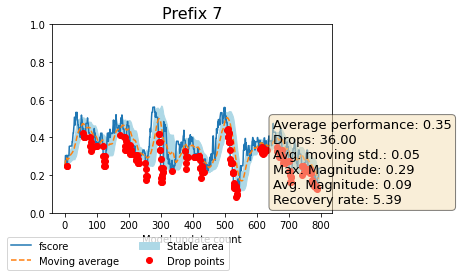

../img/OIR5K/hatc/Finished cases/prefix_7_fscore update.png


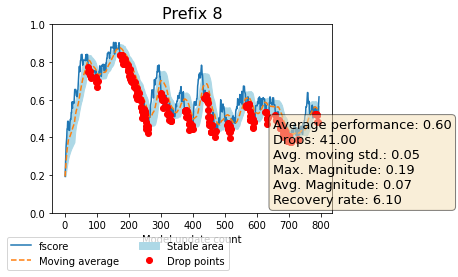

../img/OIR5K/hatc/Finished cases/prefix_8_fscore update.png


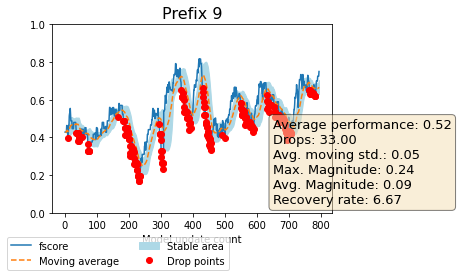

../img/OIR5K/hatc/Finished cases/prefix_9_fscore update.png


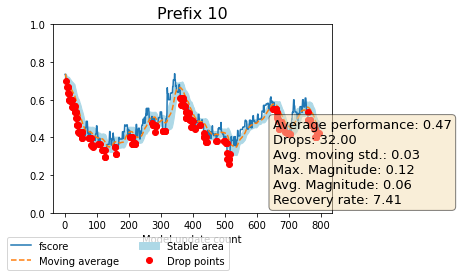

../img/OIR5K/hatc/Finished cases/prefix_10_fscore update.png


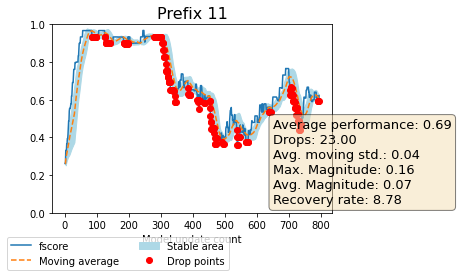

../img/OIR5K/hatc/Finished cases/prefix_11_fscore update.png


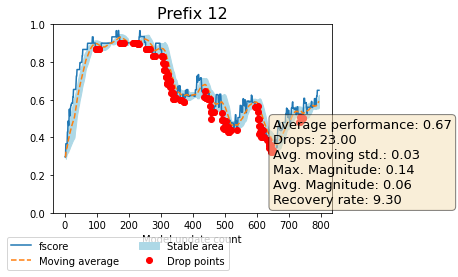

../img/OIR5K/hatc/Finished cases/prefix_12_fscore update.png


In [31]:
dataset = 'OIR5K'
classifier = 'hatc'
meta_metrics_dict = dict()
retraining = True
for prefix in range(1, 13):
    if retraining == True:
        performance = '../result/%s/%s/performance/rebalanced_True prefix_%s performance retrained.csv'%(dataset, classifier, prefix)
    else:
        performance = '../result/%s/%s/performance/rebalanced_True prefix_%s performance.csv'%(dataset, classifier, prefix)
    df = pd.read_csv(performance)
    mw_average, mw_std, outliers_pos = stability_window(df['fscore'],30)
    meta_metrics_dict[prefix] = dict()

    if len(outliers_pos) !=0:
        drop_list = list(drops(outliers_pos))
        drop_length = [i[1]- i[0] +1 for i in drop_list]
        
    x = [i for i in range(1, len(df['fscore'])+1)]
    y = df['fscore']

    if len(outliers_pos) == 0:
        drops_value = 0
        avg_std = 0
        max_magnitude = 0
        avg_magnitude = 0
        recovery_rate = 0
    else:
        drops_value = len(drop_list)
        avg_std = round(np.average(mw_std),3)
        max_magnitude = round(np.max([mw_average[i] - y[i] for i in outliers_pos]),3)
        avg_magnitude = round(np.average([mw_average[i] - y[i] for i in outliers_pos]),3)
        recovery_rate = round(np.average(drop_length),3)
    eval_metrics = '\n'.join((
    r'Average performance: %.2f' %(np.average(y)),
    r'Drops: %.2f' %(drops_value),
    r'Avg. moving std.: %.2f'%(avg_std),
    r'Max. Magnitude: %.2f'%(max_magnitude),
    r'Avg. Magnitude: %.2f'%(avg_magnitude),
    r'Recovery rate: %.2f'%(recovery_rate)
    ))

    meta_metrics_dict[prefix]['Average performance'] = round(np.average(y),3)
    meta_metrics_dict[prefix]['Drops'] = drops_value
    meta_metrics_dict[prefix]['Avg. moving std.'] = avg_std
    meta_metrics_dict[prefix]['Max. Magnitude:'] = max_magnitude
    meta_metrics_dict[prefix]['Avg. Magnitude'] = avg_magnitude
    meta_metrics_dict[prefix]['Recovery rate'] = recovery_rate
    plt.plot(x, y, label = 'fscore')

    plt.plot(x, mw_average, linestyle = '--', label='Moving average')
    plt.fill_between(x, np.array(mw_average) + np.array(mw_std), np.array(mw_average) - np.array(mw_std), color='lightblue', label='Stable area')
    
    plt.plot([x[i] for i in outliers_pos], [y[i] for i in outliers_pos], 'ro', label = 'Drop points')

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol =2)
#     plt.text(100, np.average(y), '%.2f'%(np.average(y)), va='center')   
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(650, 0.05, eval_metrics, bbox = props, fontsize = 13)
    
    
#     if dataset_label == 'bpic15' or dataset_label == 'bpic17':
#         pass
#     else:
#         plt.axvline(cdhappend[maximum_prefix], color = 'black', linestyle ='--', label = 'Concept drift')
    plt.title('Prefix %s'%(prefix), fontsize = 16)
    plt.xlabel('Model update count')
    plt.legend(bbox_to_anchor=(0.65, -0.1), ncol=2)
    plt.ylim(0,1)

    plt.tight_layout()


    # plt.show()
#     plt.savefig('../img/%s/%s/Finished cases/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method), dpi=250)
    print('../img/%s/%s/Finished cases/prefix_%s_%s update.png'%(dataset, classifier, prefix, 'fscore'))
    plt.cla()
    plt.clf()
    plt.close()
    

In [32]:
meta_metrics_dict

{1: {'Average performance': 0.651,
  'Drops': 31,
  'Avg. moving std.': 0.059,
  'Max. Magnitude:': 0.25,
  'Avg. Magnitude': 0.104,
  'Recovery rate': 7.516},
 2: {'Average performance': 0.224,
  'Drops': 31,
  'Avg. moving std.': 0.048,
  'Max. Magnitude:': 0.178,
  'Avg. Magnitude': 0.081,
  'Recovery rate': 7.032},
 3: {'Average performance': 0.436,
  'Drops': 35,
  'Avg. moving std.': 0.054,
  'Max. Magnitude:': 0.252,
  'Avg. Magnitude': 0.094,
  'Recovery rate': 6.714},
 4: {'Average performance': 0.497,
  'Drops': 40,
  'Avg. moving std.': 0.043,
  'Max. Magnitude:': 0.215,
  'Avg. Magnitude': 0.07,
  'Recovery rate': 5.775},
 5: {'Average performance': 0.464,
  'Drops': 41,
  'Avg. moving std.': 0.046,
  'Max. Magnitude:': 0.238,
  'Avg. Magnitude': 0.079,
  'Recovery rate': 5.439},
 6: {'Average performance': 0.389,
  'Drops': 41,
  'Avg. moving std.': 0.049,
  'Max. Magnitude:': 0.218,
  'Avg. Magnitude': 0.077,
  'Recovery rate': 5.244},
 7: {'Average performance': 0.347,
 

In [33]:
'../result/%s/%s/meat measures %s retrained.csv'%(dataset, classifier, 'fscore')

'../result/OIR5K/hatc/meat measures fscore retrained.csv'

In [35]:
headers = ['Prefix'] + list(meta_metrics_dict[1].keys())
table_list = []
for i in meta_metrics_dict.keys():
    rows = [i]
    for d in headers: 
        if d !='Prefix':
            rows.append(meta_metrics_dict[i][d])
    table_list.append(rows)
table = tabulate(table_list, headers=headers, tablefmt='grid')
# print(table)
# print(tabulate([(i,) +d[i] for i in d], headers = headers)) 

df = pd.DataFrame.from_dict(meta_metrics_dict).T
print(df)

if retraining == True:
    df.to_csv('../result/%s/%s/meat measures %s retrained.csv'%(dataset, classifier, 'fscore'), index=False)
else:
    df.to_csv('../result/%s/%s/meat measures %s.csv'%(dataset, classifier, 'fscore'), index=False)

    Average performance  Drops  Avg. moving std.  Max. Magnitude:  \
1                 0.651   31.0             0.059            0.250   
2                 0.224   31.0             0.048            0.178   
3                 0.436   35.0             0.054            0.252   
4                 0.497   40.0             0.043            0.215   
5                 0.464   41.0             0.046            0.238   
6                 0.389   41.0             0.049            0.218   
7                 0.347   36.0             0.052            0.290   
8                 0.599   41.0             0.047            0.190   
9                 0.521   33.0             0.051            0.243   
10                0.474   32.0             0.034            0.124   
11                0.693   23.0             0.037            0.163   
12                0.667   23.0             0.033            0.143   

    Avg. Magnitude  Recovery rate  
1            0.104          7.516  
2            0.081          7.

In [4]:
meta_metrics_dict = dict()

for prefix in score_dict.keys():
    print(prefix)
    meta_metrics_dict[prefix] = dict()
    plt.figure(figsize=(10,6))
    mw_average, mw_std, outliers_pos = stability_window(score_dict[prefix],30)

    if len(outliers_pos) !=0:
        drop_list = list(drops(outliers_pos))
        drop_length = [i[1]- i[0] +1 for i in drop_list]
    
    x = [i for i in range(1, len(score_dict[prefix])+1)]
    y = score_dict[prefix]
    plt.plot(x, score_dict[prefix], label = evaluation_method)

    plt.plot(x, mw_average, linestyle = '--', label='Moving average')
    plt.fill_between(x, np.array(mw_average) + np.array(mw_std), np.array(mw_average) - np.array(mw_std), color='lightblue', label='Stable area')
    
    plt.plot([x[i] for i in outliers_pos], [y[i] for i in outliers_pos], 'ro', label = 'Drop points')

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol =2)
    plt.tight_layout()
#     plt.text(100, np.average(y), '%.2f'%(np.average(y)), va='center')   
    
    if len(outliers_pos) == 0:
        drops_value = 0
        avg_std = 0
        max_magnitude = 0
        avg_magnitude = 0
        recovery_rate = 0
    else:
        drops_value = len(drop_list)
        avg_std = np.average(mw_std)
        max_magnitude = np.max([mw_average[i] - y[i] for i in outliers_pos])
        avg_magnitude = np.average([mw_average[i] - y[i] for i in outliers_pos])
        recovery_rate = np.average(drop_length)
    eval_metrics = '\n'.join((
    r'Average performance: %.2f' %(np.average(y)),
    r'Drops: %.2f' %(drops_value),
    r'Avg. moving std.: %.2f'%(avg_std),
    r'Max. Magnitude: %.2f'%(max_magnitude),
    r'Avg. Magnitude: %.2f'%(avg_magnitude),
    r'Recovery rate: %.2f'%(recovery_rate)
    ))
    
    meta_metrics_dict[prefix]['Average performance'] = np.average(y)
    meta_metrics_dict[prefix]['Drops'] = drops_value
    meta_metrics_dict[prefix]['Avg. moving std.'] = avg_std
    meta_metrics_dict[prefix]['Max. Magnitude:'] = max_magnitude
    meta_metrics_dict[prefix]['Avg. Magnitude'] = avg_magnitude
    meta_metrics_dict[prefix]['Recovery rate'] = recovery_rate
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    plt.text(650, 0.05, eval_metrics, bbox = props, fontsize = 13)
    
    
#     if dataset_label == 'bpic15' or dataset_label == 'bpic17':
#         pass
#     else:
#         plt.axvline(cdhappend[maximum_prefix], color = 'black', linestyle ='--', label = 'Concept drift')
    plt.title('Prefix %s'%(prefix), fontsize = 16)
    plt.xlabel('Model update count')
    plt.legend(bbox_to_anchor=(0.65, -0.1), ncol=2)
    plt.ylim(0,1)

    if os.path.exists('./img/%s/%s/%s'%(dataset_label, classifier, 'Finished cases')) == False:
        os.makedirs('./img/%s/%s/%s'%(dataset_label, classifier, 'Finished cases'))
    if os.path.exists('./result/%s/%s/%s'%(dataset_label, classifier, 'Finished cases')) == False:
        os.makedirs('./result/%s/%s/%s'%(dataset_label, classifier, 'Finished cases'))


#     with open('./result/%s/%s/Finished cases/prefix_%s_%s update.pkl'%(dataset_label, classifier, prefix, evaluation_method), 'wb') as f:
#         pkl.dump(result, f)
    plt.tight_layout()

#     if prefix == 7 or prefix == 14:
#         a = plt.gca()
#         yax = a.axes.get_yaxis()
#         yax = yax.set_visible(False)
    plt.show()
#     plt.savefig('../img/%s/%s/Finished cases/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method), dpi=250)
    print('../img/%s/%s/Finished cases/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method))
    plt.cla()
    plt.clf()
    plt.close()

NameError: name 'score_dict' is not defined

In [39]:
dataset = 'bpic17'
classifier = 'hatc'
meta_metrics_dict = dict()
retraining = False
for prefix in range(1, 13):
    if retraining == True:
        performance = '../result/%s/%s/performance/rebalanced_True prefix_%s performance retrained.csv'%(dataset, classifier, prefix)
    else:
        performance = '../result/%s/%s/performance/rebalanced_True prefix_%s performance.csv'%(dataset, classifier, prefix)
    df = pd.read_csv(performance)
    mw_average, mw_std, outliers_pos = stability_window(df['fscore'],30)
    print(round(np.average(df['fscore']),3))





0.104
0.47
0.472
0.55
0.534
0.327
0.687
0.392
0.549
0.487
0.597
0.664


In [45]:
dataset = 'oir5k'
classifier = 'xgb'
meta_metrics_dict = dict()
retraining = False
variant =pd.read_csv('../result/%s/%s/rebalanced_True label.csv'%(dataset, classifier))
for i in variant.columns.values:
    print(round(np.average(variant[i]),3))



0.246
0.246
0.246
0.246
0.246
0.246
0.246
0.246
0.326
0.442
0.442
0.457
